#Library

In [1]:
import numpy as np
import pandas as pd
import string
import re

!pip install symspellpy
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

!pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot
plt.rcParams['figure.figsize'] = 8, 5
plt.style.use("fivethirtyeight")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 9.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Skripsi/Data/blibli2000.csv'

df = pd.read_csv(file_path, encoding='latin1')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              2000 non-null   object 
 1   userName              2000 non-null   object 
 2   userImage             2000 non-null   object 
 3   content               2000 non-null   object 
 4   score                 2000 non-null   int64  
 5   thumbsUpCount         1157 non-null   float64
 6   reviewCreatedVersion  1798 non-null   object 
 7   at                    2000 non-null   object 
 8   replayContent         2000 non-null   object 
 9   repliedAt             2000 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 156.4+ KB


#data cleaning

In [4]:
def clean_text(text):
    text = str(text)
    return re.sub('[^a-zA-Z]', ' ', text)

df['cleaned'] = df['content'].apply(lambda x: clean_text(x))
df['cleaned']

,cleaned
0,Worst ecomm in Indonesia Totally rubbish for ...
1,The application is getting worse every time y...
2,I have successfully delete my blibli account t...
3,simple and best application for online shopping
4,Superb Original products super fast...
...,...
1995,Love it Very helpful
1996,Very nice online shoping
1997,Transaction auto cancelled by system WTH
1998,Powerfull app for daily



#Normalization (slang words)

In [5]:
# SymSpell
max_edit_distance_dictionary = 2
prefix_length = 7
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")

sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

def correct_typo(text):
    tokens = word_tokenize(text)

    corrected_tokens = [correct_typo_token(token) for token in tokens]

    corrected_text = ' '.join(corrected_tokens)

    return corrected_text

def correct_typo_token(token):
    suggestions = sym_spell.lookup(token, Verbosity.CLOSEST, max_edit_distance=2)
    if suggestions:
        return suggestions[0].term
    return token

df['corrected'] = df['cleaned'].apply(correct_typo)

print(df[['corrected', 'cleaned']])

                                              corrected  \
0     worst comm in indonesia totally rubbish for it...   
1     the application is getting worse every time yo...   
2     a have successfully delete my bible account th...   
3       simple and best application for online shopping   
4     superb original products super fast shipping a...   
...                                                 ...   
1995                               love it very helpful   
1996                          very nice online shopping   
1997           transaction auto cancelled by system WTH   
1998                             powerful app for daily   
1999                                 promo all the time   

                                                cleaned  
0     Worst ecomm in Indonesia  Totally rubbish for ...  
1     The application is getting worse  every time y...  
2     I have successfully delete my blibli account t...  
3      simple and best application for online shopping   
4

#case folding

In [6]:
def cleanreview(text):
  text = text.lower()

  return text

df['cleaned_text'] = df['corrected'].apply(cleanreview)
df['cleaned_text']

,cleaned_text
0,worst comm in indonesia totally rubbish for it...
1,the application is getting worse every time yo...
2,a have successfully delete my bible account th...
3,simple and best application for online shopping
4,superb original products super fast shipping a...
...,...
1995,love it very helpful
1996,very nice online shopping
1997,transaction auto cancelled by system wth
1998,powerful app for daily


#Additional Features

In [7]:
# Pendefinisian label
def label_sentiment(score):
    score = int(score)
    if score < 3:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

df['label'] = df['score'].apply(label_sentiment)

In [8]:
df['label'].value_counts()

,count
label,
positive,1514
negative,432
neutral,54


In [9]:
def count_punct(text):
    if len(text) - text.count(" ") == 0:
        return 0
    else:
        count = sum([1 for char in text if char in string.punctuation])
        return round(count / (len(text) - text.count(" ")), 3) * 100

df['Review_len'] = df['cleaned_text'].apply(lambda x: len(x) - x.count(" "))
df['punct'] = df['cleaned_text'].apply(lambda x: count_punct(x))

#tokenization

In [11]:
def tokenize_text(text):
  tokenized_text = text.split()
  return tokenized_text
df['tokens'] = df['cleaned_text'].apply(lambda x: tokenize_text(x))
df['tokens']

,tokens
0,"[worst, comm, in, indonesia, totally, rubbish,..."
1,"[the, application, is, getting, worse, every, ..."
2,"[a, have, successfully, delete, my, bible, acc..."
3,"[simple, and, best, application, for, online, ..."
4,"[superb, original, products, super, fast, ship..."
...,...
1995,"[love, it, very, helpful]"
1996,"[very, nice, online, shopping]"
1997,"[transaction, auto, cancelled, by, system, wth]"
1998,"[powerful, app, for, daily]"


# Stopwords and Lemmatization

In [12]:
# WordNetLemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return lemmatized_tokens

df['cleaned'] = df['tokens'].apply(preprocess_text)
df['cleaned']

,cleaned
0,"[worst, comm, indonesia, totally, rubbish, int..."
1,"[application, getting, worse, every, time, wan..."
2,"[successfully, delete, bible, account, year, v..."
3,"[simple, best, application, online, shopping]"
4,"[superb, original, product, super, fast, shipp..."
...,...
1995,"[love, helpful]"
1996,"[nice, online, shopping]"
1997,"[transaction, auto, cancelled, system, wth]"
1998,"[powerful, app, daily]"


#Explore

In [15]:
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              2000 non-null   object 
 1   userName              2000 non-null   object 
 2   userImage             2000 non-null   object 
 3   content               2000 non-null   object 
 4   score                 2000 non-null   int64  
 5   thumbsUpCount         1157 non-null   float64
 6   reviewCreatedVersion  1798 non-null   object 
 7   at                    2000 non-null   object 
 8   replayContent         2000 non-null   object 
 9   repliedAt             2000 non-null   object 
 10  cleaned               2000 non-null   object 
 11  corrected             2000 non-null   object 
 12  cleaned_text          2000 non-null   object 
 13  label                 2000 non-null   object 
 14  Review_len            2000 non-null   int64  
 15  punct                

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replayContent,repliedAt,cleaned,corrected,cleaned_text,label,Review_len,punct,tokens
0,4f4e0ef1-7b88-484e-a271-cf4cb83ac771,michael yohanes,https://play-lh.googleusercontent.com/a-/ALV-U...,"Worst ecomm in Indonesia, Totally rubbish for ...",1,4.0,11.1.0,5/4/2024 13:34,Halo michael we are very sorry about the incon...,5/5/2024 5:00,"[worst, comm, indonesia, totally, rubbish, int...",worst comm in indonesia totally rubbish for it...,worst comm in indonesia totally rubbish for it...,negative,392,0.0,"[worst, comm, in, indonesia, totally, rubbish,..."
1,3beee8df-d740-45a1-aa21-5094cd50aac9,Okta Utama Yuniar,https://play-lh.googleusercontent.com/a-/ALV-U...,"The application is getting worse, every time y...",1,14.0,11.0.0,3/21/2024 21:36,Hi Okta Utama Yuniar We are deeply sorry about...,3/23/2024 12:10,"[application, getting, worse, every, time, wan...",the application is getting worse every time yo...,the application is getting worse every time yo...,negative,182,0.0,"[the, application, is, getting, worse, every, ..."
2,87abdc55-e858-4f7e-a18d-1521e9bd9d52,John Beast,https://play-lh.googleusercontent.com/a-/ALV-U...,I have successfully delete my blibli account t...,1,8.0,NaN,3/21/2024 1:33,Hi John We apologize for giving you the unplea...,3/21/2024 7:12,"[successfully, delete, bible, account, year, v...",a have successfully delete my bible account th...,a have successfully delete my bible account th...,negative,397,0.0,"[a, have, successfully, delete, my, bible, acc..."


Word cloud

In [16]:
!pip install -U beautifulsoup4

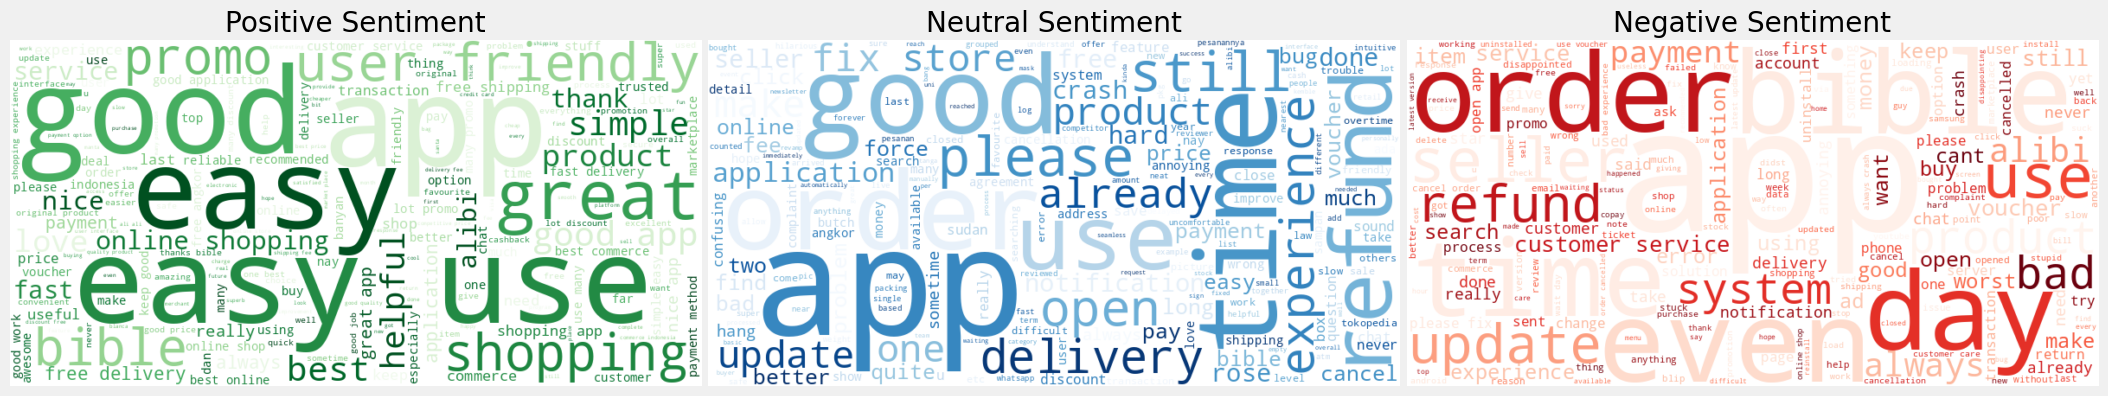

In [17]:
from wordcloud import WordCloud

df2 = df.copy()
df2['original'] = df2['cleaned'].apply(lambda tokens: ' '.join(tokens))

positive_words = ' '.join(text for text in df2['original'][df2['label'] == 'positive'])
neutral_words = ' '.join(text for text in df2['original'][df2['label'] == 'neutral'])
negative_words = ' '.join(text for text in df2['original'][df2['label'] == 'negative'])

def plot_wordCloud(text, colormap, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(24, 8), gridspec_kw={'wspace': 0.01})

plot_wordCloud(positive_words, 'Greens', axs[0])
axs[0].set_title('Positive Sentiment')

plot_wordCloud(neutral_words, 'Blues', axs[1])
axs[1].set_title('Neutral Sentiment')

plot_wordCloud(negative_words, 'Reds', axs[2])
axs[2].set_title('Negative Sentiment')

plt.show()

score distribution

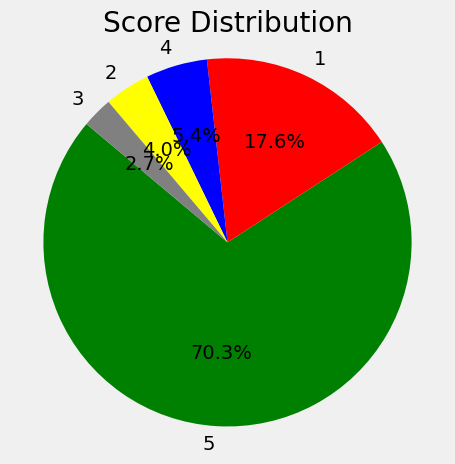

In [18]:
value_counts = df['score'].value_counts()

colors = {1: 'red', 2: 'yellow', 3: 'gray', 4: 'blue', 5: 'green'}
color_list = [colors[i] for i in value_counts.index]

plt.figure(figsize=(5, 5))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, colors=color_list)
plt.title('Score Distribution')
plt.axis('equal')
plt.show()

label distribution

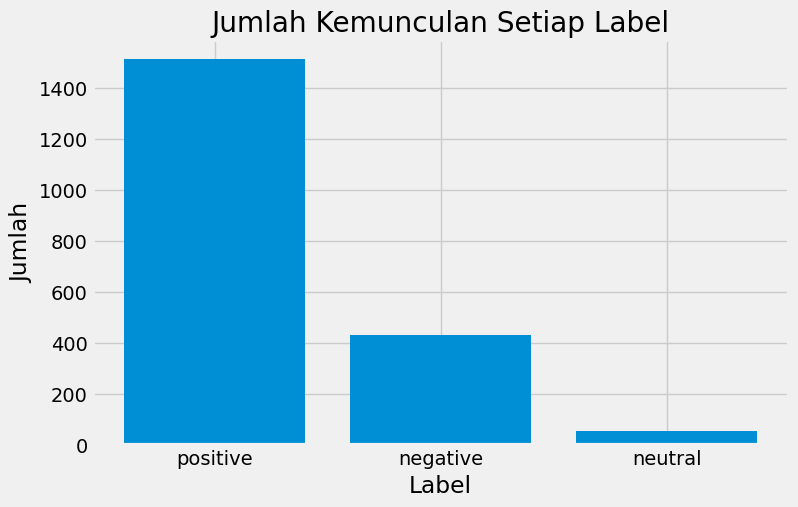

In [19]:
value_counts2 = df['label'].value_counts()

plt.bar(value_counts2.index, value_counts2.values)

plt.xlabel('Label')
plt.ylabel('Jumlah')
plt.title('Jumlah Kemunculan Setiap Label')

plt.show()

#Feature Extraction

In [20]:
X = df[['cleaned', 'Review_len', 'punct']]
y = df['label']
print(X.shape)
print(y.shape)

(2000, 3)
(2000,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state= 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1600, 3)
(400, 3)
(1600,)
(400,)


In [23]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

result = pd.DataFrame({
    'jenis data': ['Train', 'Test'],
    'positive': [train_counts.get('positive', 0), test_counts.get('positive', 0)],
    'neutral': [train_counts.get('neutral', 0), test_counts.get('neutral', 0)],
    'negative': [train_counts.get('negative', 0), test_counts.get('negative', 0)],
    'total': [y_train.shape[0], y_test.shape[0]]
})

print(result)

  jenis data  positive  neutral  negative  total
0      Train      1228       36       336   1600
1       Test       286       18        96    400


TF-IDF

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train_text = X_train['cleaned'].apply(lambda x: ' '.join(x))
X_test_text = X_test['cleaned'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1,2), stop_words='english', norm='l2')

tfidf_train = tfidf.fit_transform(X_train_text)
tfidf_test = tfidf.transform(X_test_text)

X_train_vect = pd.concat([X_train[['Review_len', 'punct']].reset_index(drop=True),
                          pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['Review_len', 'punct']].reset_index(drop=True),
                         pd.DataFrame(tfidf_test.toarray())], axis=1)

print(X_train_vect)

      Review_len  punct    0    1    2    3    4    5    6    7  ...  1762  \
0             42    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1            145    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
2             47    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
3             86    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
4             79    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
...          ...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
1595          50    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1596          36    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1597          19    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1598         107    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   
1599          56    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   0.0   

      1763  1764  1765  1766  1767  1768  1769  1770  1771  
0 

In [25]:
tfidf_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf.get_feature_names_out())
tfidf_mean = tfidf_df.mean().sort_values(ascending=False).head(12)

print(tfidf_mean)

easy        0.056512
good        0.043887
app         0.038585
use         0.037743
easy use    0.033777
shopping    0.028338
apps        0.026042
simple      0.021756
great       0.021568
best        0.020594
online      0.020530
user        0.019906
dtype: float64


In [26]:
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

#Model

##Multinomial Naive Bayes

Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.89      0.82        96
     neutral       0.00      0.00      0.00        18
    positive       0.93      0.94      0.94       286

    accuracy                           0.89       400
   macro avg       0.57      0.61      0.59       400
weighted avg       0.85      0.89      0.87       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



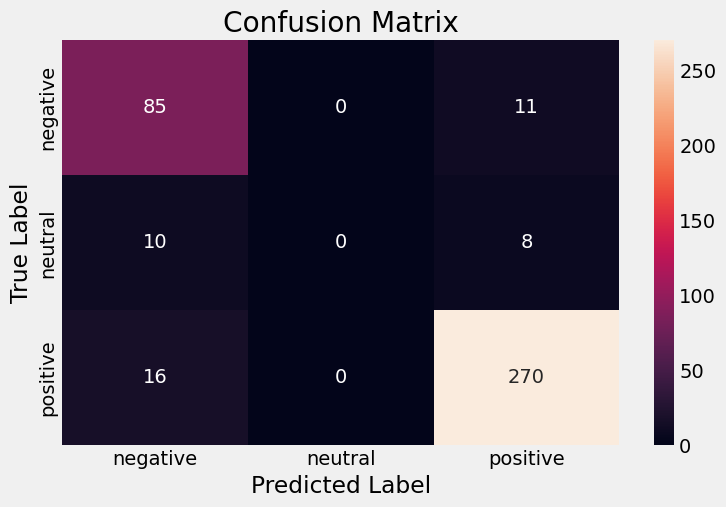

In [27]:
from sklearn.naive_bayes import MultinomialNB

# Inisialisasi model Naive Bayes
classifier = MultinomialNB()

# grid hyperparameter
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Latih model dengan grid search
grid_search.fit(X_train_vect, y_train)

# Dapatkan model terbaik setelah tuning
best_classifier_mnb = grid_search.best_estimator_

# Lakukan prediksi dengan model terbaik
naive_bayes_pred = best_classifier_mnb.predict(X_test_vect)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, naive_bayes_pred))

# Confusion Matrix
class_labels = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, naive_bayes_pred), index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# # Cetak hyperparameter dari model terbaik
# print("Hyperparameters from the best model:")
# print(grid_search.best_params_)

# # Menampilkan hasil akurasi dari setiap kombinasi hyperparameter
# results = []

# for params in grid_search.cv_results_['params']:
#     # Buat model dengan kombinasi hyperparameter saat ini
#     model = MultinomialNB(**params)
#     model.fit(X_train_vect, y_train)
#     # Prediksi pada set uji
#     predictions = model.predict(X_test_vect)
#     # Hitung akurasi
#     accuracy = accuracy_score(y_test, predictions)
#     # Simpan hasil
#     results.append({'Hyperparameters': params, 'Accuracy': accuracy})

# # Buat DataFrame dari hasil
# results_df = pd.DataFrame(results)

# print("Hasil akurasi dari setiap kombinasi hyperparameter pada set uji:")
# print(results_df)

##Random Forest

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.75      0.78        96
     neutral       1.00      0.06      0.11        18
    positive       0.89      0.97      0.93       286

    accuracy                           0.87       400
   macro avg       0.90      0.59      0.60       400
weighted avg       0.88      0.87      0.85       400



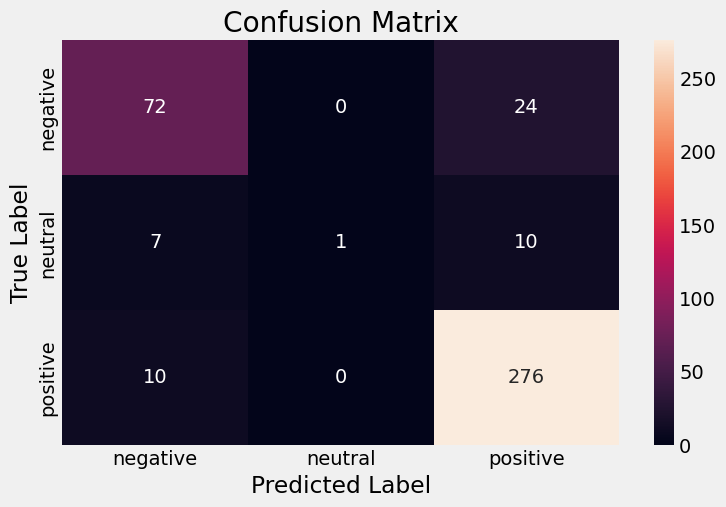

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Inisialisasi model RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=150, random_state=9)

# grid hyperparameter
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20]
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy')

# Latih model dengan grid search
grid_search.fit(X_train_vect, y_train)

# Dapatkan model terbaik setelah tuning
best_classifier_rf = grid_search.best_estimator_

# Lakukan prediksi dengan model terbaik
random_forest_pred = best_classifier_rf.predict(X_test_vect)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, random_forest_pred))

# Confusion Matrix
class_labels = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, random_forest_pred), index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# # Cetak hyperparameter dari model terbaik
# print("Hyperparameters from the best model:")
# print(grid_search.best_params_)

# # Menampilkan hasil akurasi dari setiap kombinasi hyperparameter
# results = []

# for params in grid_search.cv_results_['params']:
#     # Buat model dengan kombinasi hyperparameter saat ini
#     model = RandomForestClassifier(**params)
#     model.fit(X_train_vect, y_train)
#     # Prediksi pada set uji
#     predictions = model.predict(X_test_vect)
#     # Hitung akurasi
#     accuracy = accuracy_score(y_test, predictions)
#     # Simpan hasil
#     results.append({'Hyperparameters': params, 'Accuracy': accuracy})

# # Buat DataFrame dari hasil
# results_df = pd.DataFrame(results)

# print("Hasil akurasi dari setiap kombinasi hyperparameter pada set uji:")
# print(results_df)

##Extra Trees Classifier

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.76      0.77        96
     neutral       0.33      0.06      0.10        18
    positive       0.90      0.95      0.93       286

    accuracy                           0.87       400
   macro avg       0.67      0.59      0.60       400
weighted avg       0.85      0.87      0.85       400



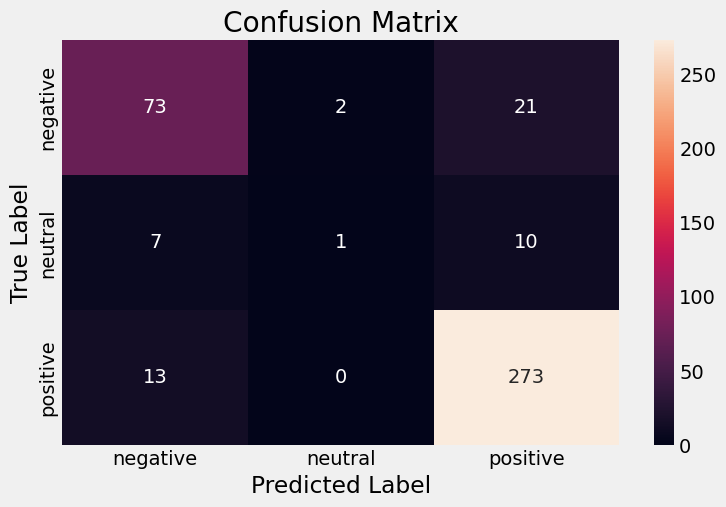

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

# Inisialisasi model ExtraTreesClassifier
classifier = ExtraTreesClassifier(n_estimators=150, random_state=50)

# grid hyperparameter
param_grid = {
    'n_estimators': [100, 125, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy')

# Latih model dengan grid search
grid_search.fit(X_train_vect, y_train)

# Dapatkan model terbaik setelah penalaan
best_classifier_etc = grid_search.best_estimator_

# Lakukan prediksi dengan model terbaik
extra_trees_pred = best_classifier_etc.predict(X_test_vect)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, extra_trees_pred))

# Confusion Matrix
class_labels = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, extra_trees_pred), index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# # Cetak hyperparameter dari model terbaik
# print("Hyperparameters from the best model:")
# print(grid_search.best_params_)

# # Menampilkan hasil akurasi dari setiap kombinasi hyperparameter
# results = []

# for params in grid_search.cv_results_['params']:
#     # Buat model dengan kombinasi hyperparameter saat ini
#     model = ExtraTreesClassifier(**params)
#     model.fit(X_train_vect, y_train)
#     # Prediksi pada set uji
#     predictions = model.predict(X_test_vect)
#     # Hitung akurasi
#     accuracy = accuracy_score(y_test, predictions)
#     # Simpan hasil
#     results.append({'Hyperparameters': params, 'Accuracy': accuracy})

# # Buat DataFrame dari hasil
# results_df = pd.DataFrame(results)

# print("Hasil akurasi dari setiap kombinasi hyperparameter pada set uji:")
# print(results_df)

##SVM

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.82      0.79        96
     neutral       0.00      0.00      0.00        18
    positive       0.92      0.95      0.93       286

    accuracy                           0.88       400
   macro avg       0.56      0.59      0.57       400
weighted avg       0.84      0.88      0.86       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



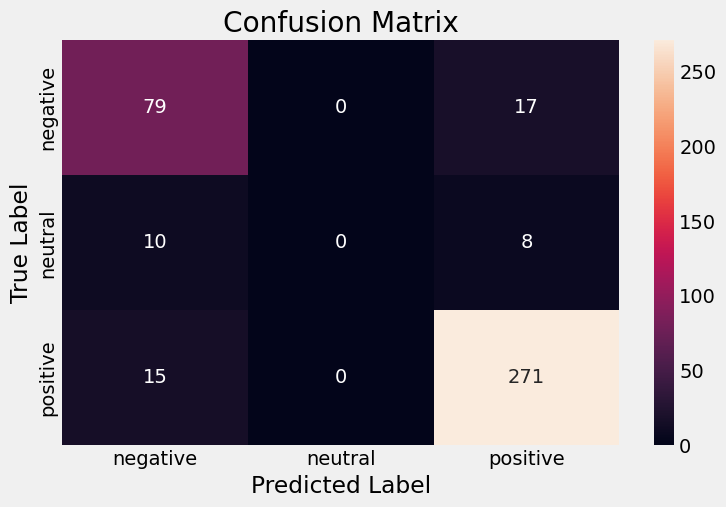

In [30]:
from sklearn.svm import SVC, LinearSVC

# Inisialisasi model SVM
classifier = SVC(kernel='linear', random_state=0)

# grid hyperparameter
param_grid = {
    'C': [0.1, 1, 10]
   # 'gamma': ['scale', 'auto']
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy')

# Latih model dengan grid search
grid_search.fit(X_train_vect, y_train)

# Dapatkan model terbaik setelah penalaan
best_classifier_svm = grid_search.best_estimator_

# Lakukan prediksi dengan model terbaik
svm_pred = best_classifier_svm.predict(X_test_vect)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, svm_pred))

# Confusion Matrix
class_labels = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, svm_pred), index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# # Cetak hyperparameter dari model terbaik
# print("Hyperparameters from the best model:")
# print(grid_search.best_params_)

# # Menampilkan hasil akurasi dari setiap kombinasi hyperparameter
# results = []

# for params in grid_search.cv_results_['params']:
#     # Buat model dengan kombinasi hyperparameter saat ini
#     model = SVC(**params)
#     model.fit(X_train_vect, y_train)
#     # Prediksi pada set uji
#     predictions = model.predict(X_test_vect)
#     # Hitung akurasi
#     accuracy = accuracy_score(y_test, predictions)
#     # Simpan hasil
#     results.append({'Hyperparameters': params, 'Accuracy': accuracy})

# # Buat DataFrame dari hasil
# results_df = pd.DataFrame(results)

# print("Hasil akurasi dari setiap kombinasi hyperparameter pada set uji:")
# print(results_df)

##Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning:

Setting penalty=None will ignore the C and l1_ratio parameters

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning:

`penalty='none'`has been deprecated in 1.2 and will be

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.81      0.80        96
     neutral       0.14      0.06      0.08        18
    positive       0.92      0.94      0.93       286

    accuracy                           0.87       400
   macro avg       0.62      0.60      0.60       400
weighted avg       0.85      0.87      0.86       400



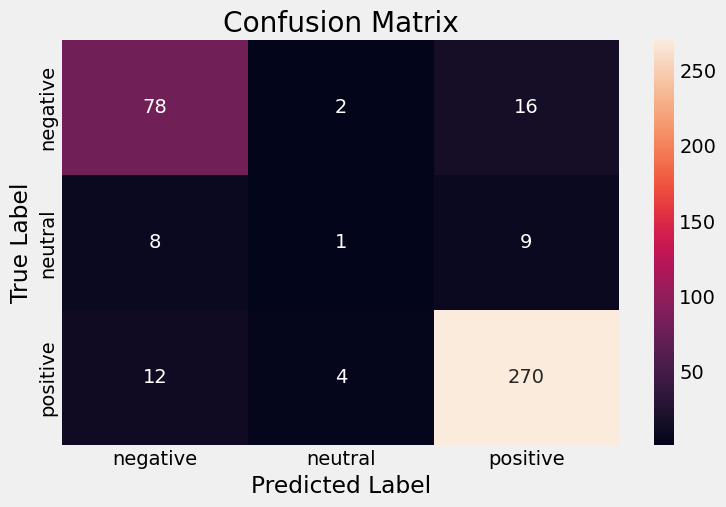

In [31]:
from sklearn.linear_model import LogisticRegression

# Inisialisasi model LogisticRegression
classifier = LogisticRegression()

# Tentukan grid hyperparameter yang ingin Anda jelajahi
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 150]
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=3, scoring='accuracy')

# Latih model dengan grid search
grid_search.fit(X_train_vect, y_train)

# Dapatkan model terbaik setelah tuning
best_classifier_lr = grid_search.best_estimator_

# Lakukan prediksi dengan model terbaik
log_reg_pred = best_classifier_lr.predict(X_test_vect)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, log_reg_pred))

# Confusion Matrix
class_labels = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, log_reg_pred), index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# # Cetak hyperparameter dari model terbaik
# print("Hyperparameters from the best model:")
# print(grid_search.best_params_)

# # Menampilkan hasil akurasi dari setiap kombinasi hyperparameter
# results = []

# for params in grid_search.cv_results_['params']:
#     # Buat model dengan kombinasi hyperparameter saat ini
#     model = LogisticRegression(**params)
#     model.fit(X_train_vect, y_train)
#     # Prediksi pada set uji
#     predictions = model.predict(X_test_vect)
#     # Hitung akurasi
#     accuracy = accuracy_score(y_test, predictions)
#     # Simpan hasil
#     results.append({'Hyperparameters': params, 'Accuracy': accuracy})

# # Buat DataFrame dari hasil
# results_df = pd.DataFrame(results)

# print("Hasil akurasi dari setiap kombinasi hyperparameter pada set uji:")
# print(results_df)

##KNN

Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.38      0.46        96
     neutral       0.00      0.00      0.00        18
    positive       0.79      0.93      0.85       286

    accuracy                           0.76       400
   macro avg       0.46      0.44      0.44       400
weighted avg       0.70      0.76      0.72       400



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



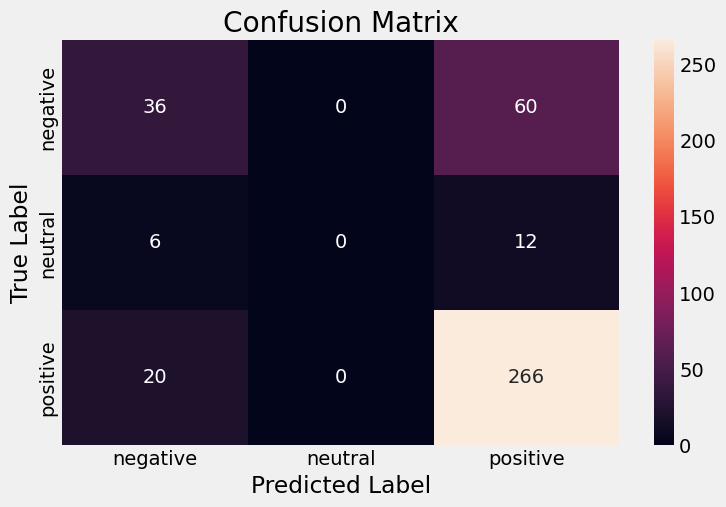

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# Inisialisasi model KNN
classifier = KNeighborsClassifier()

# Tentukan grid hyperparameter yang ingin Anda jelajahi
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Latih model dengan grid search
grid_search.fit(X_train_vect, y_train)

# Dapatkan model terbaik setelah tuning
best_classifier_knn = grid_search.best_estimator_

# Lakukan prediksi dengan model terbaik
knn_pred = best_classifier_knn.predict(X_test_vect)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, knn_pred))

# Confusion Matrix
class_labels = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(confusion_matrix(y_test, knn_pred), index=class_labels, columns=class_labels)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# # Cetak hyperparameter dari model terbaik
# print("Hyperparameters from the best model:")
# print(grid_search.best_params_)

# # Menampilkan hasil akurasi dari setiap kombinasi hyperparameter
# results = []

# for params in grid_search.cv_results_['params']:
#     # Buat model dengan kombinasi hyperparameter saat ini
#     model = KNeighborsClassifier(**params)
#     model.fit(X_train_vect, y_train)
#     # Prediksi pada set uji
#     predictions = model.predict(X_test_vect)
#     # Hitung akurasi
#     accuracy = accuracy_score(y_test, predictions)
#     # Simpan hasil
#     results.append({'Hyperparameters': params, 'Accuracy': accuracy})

# # Buat DataFrame dari hasil
# results_df = pd.DataFrame(results)

# print("Hasil akurasi dari setiap kombinasi hyperparameter pada set uji:")
# print(results_df)

#Predictions

In [33]:
pred = pd.DataFrame({
    'Ulasan': df.loc[X_test.index, 'content'],
    'Sentimen': naive_bayes_pred
})

print(pred)

                                                 Ulasan  Sentimen
405                                      prudent & save  positive
1190  Running smoothly Great app to shop online Reco...  positive
1132  Helpful apps and great to have sale of the uni...  positive
731   after update, all the link just wont response....  negative
1754                        Bad disturbing cutting ads.  negative
...                                                 ...       ...
638   Unsupported Customer Service = uninstall then ...  negative
360   Attentive and great app but lack of good UX es...  positive
1810                    Fast delivery. Original product  positive
1743  so experience app, absolutely perfect #chatwhe...  negative
563   Payment failed, refund need 15 working days!? ...  negative

[400 rows x 2 columns]


In [ ]:
pred = pd.DataFrame(pred)

pred.to_csv('/content/drive/My Drive/Skripsi/blibli_pred.csv', index=False)

#Visualization

In [34]:
results_df = pd.DataFrame({
    'Ulasan': X_test['cleaned'],
    'Sentimen': naive_bayes_pred
})

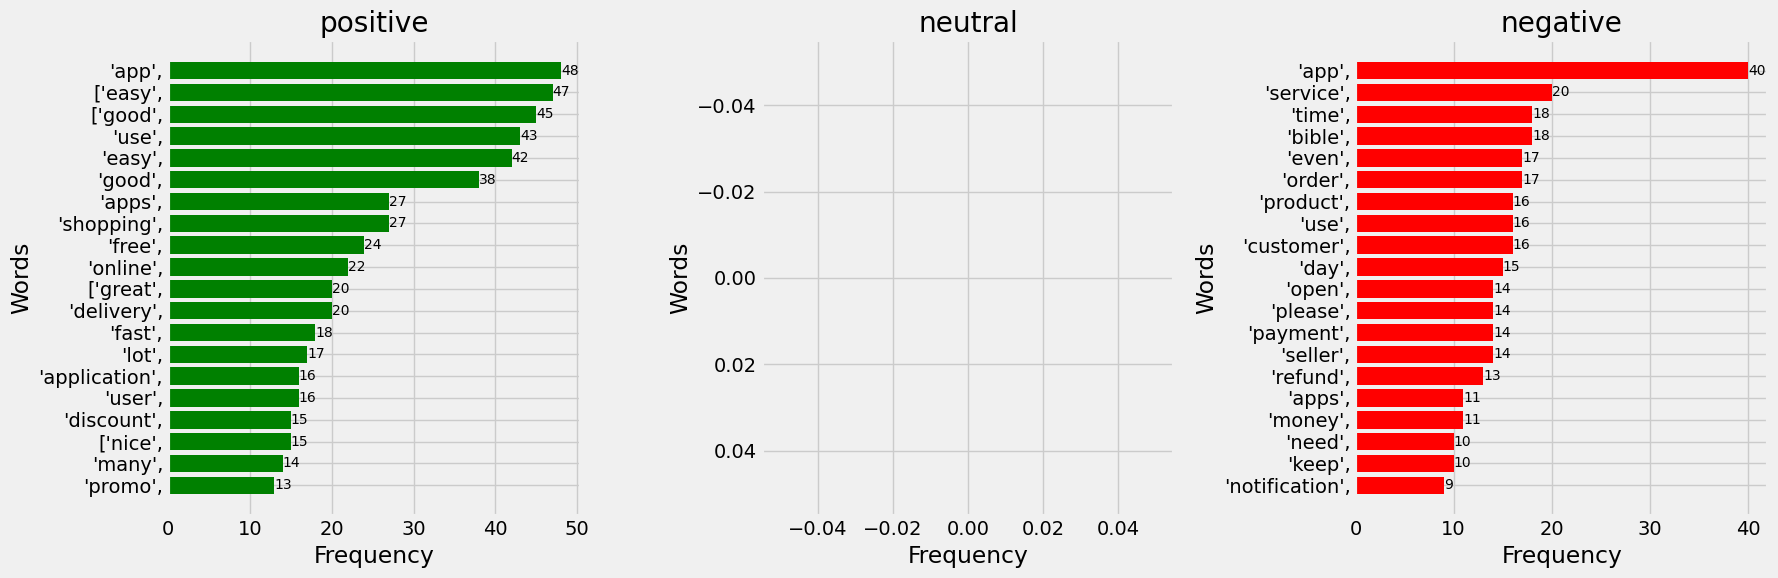

In [35]:
from collections import Counter

def get_top_n_words(corpus, n=None):
    combined_text = ' '.join(map(str, corpus))
    words = combined_text.split()
    word_counts = Counter(words)
    return word_counts.most_common(n)

colors = {
    'positive': 'green',
    'neutral': 'blue',
    'negative': 'red'
}

sentiments = ['positive', 'neutral', 'negative']

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, sentiment in enumerate(sentiments):
    subset = results_df[results_df['Sentimen'] == sentiment]
    top_words = get_top_n_words(subset['Ulasan'], 20)

    top_words.sort(key=lambda x: x[1], reverse=True)

    words = [word for word, freq in top_words]
    freqs = [freq for word, freq in top_words]

    axs[i].barh(words, freqs, color=colors[sentiment])
    axs[i].set_title(f'{sentiment}')
    axs[i].set_xlabel('Frequency')
    axs[i].set_ylabel('Words')

    for j in range(len(words)):
        axs[i].text(freqs[j], j, str(freqs[j]), va='center', ha='left', fontsize=10, color='black')

    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()